based on: [0.483662871, 1.0, 26.2359775, 0.00111820675, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]

returned NPV for the number of reactors [10584234.36989537, 10619217.463052887, 10654200.556210406, 10689183.649367923, 10724166.742525442, 10759149.835682958, 10794132.928840477, 10829116.021997994, 10864099.115155512, 10899082.20831303]
returned NPV for temperature [10585495.881161923, 10584486.935808586, 10583354.552073402, 10582012.507853094, 10580400.989515524, 33737122890.439342, 4816942951055.888, 15455859661515.197, 27164355727287.344, 37040107846983.59, 44332729279931.84, 48812340375649.22, 50168232725873.78, 47992264468476.95, 31029371560294.766]
returned NPV for debt [10585674.555232147, 10587298.947765334, 10588926.408308163, 10590556.944393268, 10592190.563575603, 10593827.273432517, 10595467.081563842, 10597109.995591957, 10598756.02316187, 10600405.171941303, 10602057.44962076, 10603712.863913612, 10605371.422556177, 10607033.133307796, 10608698.003950909, 10610366.042291142, 1061

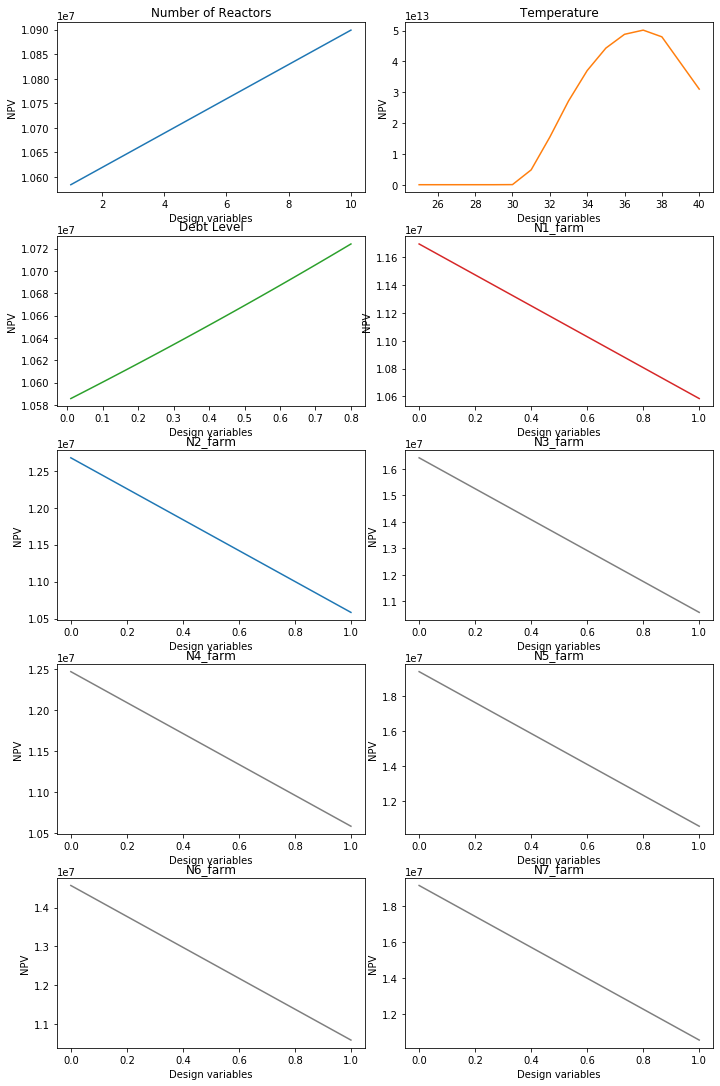

In [151]:
import pandas as pd
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from sko.GA import GA

from constants import *
from sensitivity_cost_module import do_all_list_cp,system_npv,JtokWh ,farmer_npv
from digesterModule import digester
import sensitivity_cost_module as C2
import Transport as T
import biogas as B
import pickle
from math import inf

# Variables we want to keep track in DOE
farm=[]
system=[]
# with open('data_transport.p', 'rb') as fp:
#     dict_T = pickle.load(fp)
with open('full_transp.p', 'rb') as fp:
    dict_T = pickle.load(fp)

import matplotlib.pyplot as plt
import autograd.numpy as np

vector = [4.83662871e-01, 1.00000000e+00, 2.62359775e+01, 
        1.11820675e-03, 1.00000000e+00, 0.00000000e+00,0.00000000e+00, 
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00,0.00000000e+00]


def biodigestor(dv_n,dv_in,printt=False,pen=True):
    
    global vector
    
    ##DESIGN VARIABLES##
    n_g = 1 #number of reactor
    Tdig = vector[2] #operating temperature
    debt_level = vector[3] #Portion of total capex required funded with debt
    active_farms = np.ones(7)
    
    #print('dv_in:',dv_in)
    if dv_n==1: #Vgburn
        temp = 1
    elif dv_n==2: #generator
        n_g = dv_in
    elif dv_n==3: #temperature
        Tdig = dv_in
    elif dv_n==4: #debt
        debt_level = dv_in
    elif dv_n==5: #farm1
        active_farms[0] = dv_in
        print('farm1',dv_in)
        print(active_farms)
    elif dv_n==6: #farm2
        active_farms[1] = dv_in
        print('farm2',dv_in)
        print(active_farms)
    elif dv_n==7: #farm3
        active_farms[2] = dv_in
        print('farm3',dv_in)
        print(active_farms)
    elif dv_n==8: #farm4
        active_farms[3] = dv_in
        print('farm4',dv_in)
        print(active_farms)
    elif dv_n==9: #farm5
        active_farms[4] = dv_in
        print('farm5',dv_in)
        print(active_farms)
    elif dv_n==10: #farm6
        active_farms[5] = dv_in
        print('farm6',dv_in)
        print(active_farms)
    elif dv_n==11: #farm7
        active_farms[6] = dv_in
        print('farm7',dv_in)
        print(active_farms)
        
    

#     active_farms= vector[4:11] 
#     active_farms = [0 if num<1 else 1 for num in active_farms ]

    if printt:
        [distance, wIn, total_solids_perc, wComp] = T.load_data(*active_farms,printt)
    else:
        [distance, wIn, total_solids_perc, wComp] = dict_T[tuple(active_farms)]
    
    [W_a, typ, V_d, G_in, G_comp, digOut, digOut_comp] = digester(wIn,wComp,Tdig)
    # H_needed = JtokWh(H_needed*1000)
    # print('----')
    
    #biogas module
    V_g = B.biomethane(G_in, G_comp) #biomethane
    f_p = B.biofertilizer(digOut) 
    ghg_r, ghg_c = B.ghg(W_a, wComp, G_in, G_comp) #ghg_r: released gas, ghg_c: captured gas
    bgm_total = B.bgm_cost(G_comp, G_in, digOut)
    
    #COST Module
    V_g =V_g*working_days
    ghg = pd.DataFrame()
    ghg['ghg_lf']=ghg_r
    ghg['ghg_tech']=ghg_c
    ghg['gas']= ['CH4','CO2','NOX','SOX']
    list_ghg = []
    for gas in ['CH4','CO2','NOX','SOX']:
        list_ghg.append(ghg[ghg['gas']==gas].values.flatten().tolist())
    list_ghg = do_all_list_cp(W_a,distance,list_ghg)
    
    #print("n_g",n_g)
    V_gburn = vector[0]*V_g

    return -farmer_npv(n_g,V_gburn,V_d,typ,distance,f_p,V_g,debt_level,e_c,e_priceB,f_used,p_bf,printt,pen)



import numpy as np

print('based on:',vector)
print()

#number of reactor
ngs = np.linspace(1, 10,10)
returned_dv1 = []
for ng in ngs:
    returned_dv1.append(biodigestor(2,ng))
print('returned NPV for the number of reactors',returned_dv1)

#temperature
Tdigs = np.linspace(25, 40,15,dtype=int)
returned_dv2 = []
for dig in Tdigs:
    returned_dv2.append(biodigestor(3,dig))
print('returned NPV for temperature',returned_dv2)

#debt
debts = np.linspace(1,80,80,dtype=int)/100
returned_dv3 = []
for debt in debts:
    returned_dv3.append(biodigestor(4,debt))
print('returned NPV for debt',returned_dv3)

#farm1
farm1 = np.linspace(0,1,2,dtype=int)
returned_dv4 = []
for farm in farm1:
    returned_dv4.append(biodigestor(5,farm))
print('returned NPV for Farm1',returned_dv4)

#farm2
farm2 = np.linspace(0,1,2,dtype=int)
returned_dv5 = []
for farm in farm2:
    returned_dv5.append(biodigestor(6,farm))
print('returned NPV for Farm2',returned_dv5)

#farm3
farm3 = np.linspace(0,1,2,dtype=int)
returned_dv6 = []
for farm in farm1:
    returned_dv6.append(biodigestor(7,farm))
print('returned NPV for Farm3',returned_dv6)

#farm4
farm4 = np.linspace(0,1,2,dtype=int)
returned_dv7 = []
for farm in farm4:
    returned_dv7.append(biodigestor(8,farm))
print('returned NPV for Farm4',returned_dv6)

#farm5
farm5 = np.linspace(0,1,2,dtype=int)
returned_dv8 = []
for farm in farm5:
    returned_dv8.append(biodigestor(9,farm))
print('returned NPV for Farm5',returned_dv8)

#farm6
farm6 = np.linspace(0,1,2,dtype=int)
returned_dv9 = []
for farm in farm6:
    returned_dv9.append(biodigestor(10,farm))
print('returned NPV for Farm6',returned_dv9)

#farm7
farm7 = np.linspace(0,1,2,dtype=int)
returned_dv10 = []
for farm in farm7:
    returned_dv10.append(biodigestor(11,farm))
print('returned NPV for Farm7',returned_dv10)


fig, axs = plt.subplots(5, 2,figsize=(10,15))
axs[0, 0].plot(ngs, returned_dv1)
axs[0, 0].set_title('Number of Reactors')
axs[0, 1].plot(Tdigs, returned_dv2, 'tab:orange')
axs[0, 1].set_title('Temperature')
axs[1, 0].plot(debts, returned_dv3, 'tab:green')
axs[1, 0].set_title('Debt Level')
axs[1, 1].plot(farm1, returned_dv4, 'tab:red')
axs[1, 1].set_title('N1_farm')
axs[2, 0].plot(farm2, returned_dv5, 'tab:blue')
axs[2, 0].set_title('N2_farm')
axs[2, 1].plot(farm3, returned_dv6, 'tab:grey')
axs[2, 1].set_title('N3_farm')
axs[3, 0].plot(farm4, returned_dv7, 'tab:grey')
axs[3, 0].set_title('N4_farm')
axs[3, 1].plot(farm5, returned_dv8, 'tab:grey')
axs[3, 1].set_title('N5_farm')
axs[4, 0].plot(farm6, returned_dv9, 'tab:grey')
axs[4, 0].set_title('N6_farm')
axs[4, 1].plot(farm7, returned_dv10, 'tab:grey')
axs[4, 1].set_title('N7_farm')
fig.tight_layout()

for ax in axs.flat:
    ax.set(xlabel='Design variables', ylabel='NPV')

#tornado graph (based on the change of design variables)
#parameters
#digester: volume of reactor ()

gradient [-2.27627252e+02 -2.65211556e+02 -3.17619258e+02 -2.97049627e+02
 -2.23134503e+02 -1.69247692e+02 -1.50335606e+02 -1.48340499e+02
 -2.42785866e+02  1.30942048e+02  1.77903281e+04  3.49830932e+04
  3.49830932e+04  3.49830932e+04  3.49830932e+04  3.49830932e+04
  3.49830932e+04  3.49830932e+04  3.49830932e+04 -1.39932373e+05
 -1.39932373e+05  3.49830932e+04  3.49830932e+04  3.49830932e+04
  3.49830932e+04  3.49830932e+04  3.49830932e+04  3.49830932e+04
  3.49830932e+04 -1.39932373e+05 -1.39932373e+05  3.49830932e+04
  3.49830932e+04  3.49830932e+04  3.49830932e+04  3.49830932e+04
  3.49830932e+04  3.49830932e+04  3.49830932e+04 -1.39183465e+05
 -1.56788826e+05 -2.65211556e+02 -3.17619258e+02 -2.97049627e+02
 -2.23134503e+02 -1.69247692e+02 -1.50335606e+02 -1.48340499e+02
 -2.42785866e+02  1.30942048e+02  1.77903281e+04  3.49830932e+04
  3.49830932e+04  3.49830932e+04  3.49830932e+04  3.49830932e+04
  3.49830932e+04  3.49830932e+04  3.49830932e+04 -1.39183465e+05
 -1.56788826e+05

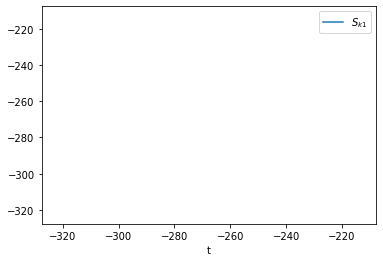

In [163]:
## GRADIENT
from autograd import grad  
grad_bio = grad(biodigestor)



print('gradient',np.gradient(np.array(returned_v, dtype=float), axis=0))


#number of reactor
ngs = np.linspace(1, 10,10)
returned_dv1 = []
for ng in ngs:
    returned_dv1.append(biodigestor(2,ng))
print('returned NPV for the number of reactors',returned_dv1)

grad = np.gradient(np.array( returned_dv1, dtype=float), axis=0)

from autograd import jacobian
#dAdk1 = jacobian(biodigestor,3)
#dAdk_1 = jacobian(biodigestor, 4)

plt.plot(ngs, grad)
#plt.plot(ngs, np.abs(dAdk_1(returned_v)))
plt.xlim([-3.27627252e+02, -2.07627252e+02])
plt.ylim([-3.27627252e+02, -2.07627252e+02])
plt.xlabel('t')
plt.legend(['$S_{k1}$', '$S_{k\_1}$'])


# plt.plot(ngs, grad(ngs))
# plt.xlim([1, 10])
# plt.ylim([46751289, 47751289])
# plt.xlabel('Number of Reactor')
# plt.ylabel('NPV')


# import autograd.numpy as np
# A0 = 1.0
# def A(t, k1, k_1):
#     return A0 / (k1 + k_1) * (k1 * np.exp(-(k1 + k_1) * t) + k_1)
# %matplotlib inline
# import matplotlib.pyplot as plt
# t = np.linspace(0, 0.5)
# k1 = 3.0
# k_1 = 3.0
# plt.plot(t, A(t, k1, k_1))
# plt.xlim([0, 0.5])
# plt.ylim([0, 1])
# plt.xlabel('t')
# plt.ylabel('A')

* Point out the design variables in the code
* confirm x* and function output
* which parameters to test with?
* All the codes are finalized? Which one I can use?
* If grad is not working, any possible workaround? e.g. gradienting the results?

In [7]:
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 22 11:34:16 2021

@author: Ricardo Hopker, Niek Jansen van Rensburg
"""
import pandas as pd
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from sko.GA import GA

from constants import *
from cost_module_funcs2 import do_all_list_cp,system_npv,JtokWh ,farmer_npv
from digesterModule2 import digester
import Transport as T
import biogas as B
import pickle
from math import inf
import scipy.optimize as op

# Variables we want to keep track in DOE
# farm=[]
# system=[]
# with open('data_transport.p', 'rb') as fp:
#     dict_T = pickle.load(fp)
with open('full_transp.p', 'rb') as fp:
    dict_T = pickle.load(fp)


# DOE = pd.read_csv('DOE.csv')
#  #Variables below are which farms should be activated

# DOE_vector=[]
# for i in range(0,18):
#     vector =  DOE.loc[i].values.flatten().tolist()
#     DOE_vector.append(vector[1:])
# DOE_n = 0
def biodigestor(vector,lam = 1,multiJ =False,full=False,printt=False,pen=True):
    #Use printt to print the text within your modules, when running the optimization it should be set to False
    #Use pen to penalize the function contraints being violated, when running the optimization it should be set to True
    # DOE_n = DOE_n+1
    # print('Design of experiment #%.0f' % (DOE_n))
    #Optimal latitude and longitude for Digestor
    #Digest_location = T.digestor_loc

    #This loads the respective farms - 1 is active, 0 is inactive. Total farms must be at least 3 active (required by annealing)
    #TOTAL_SOLIDS PERCENTAGE IS NOT USED
    active_farms= vector[5:12] 
    active_farms = [0 if num<1 or num==False  else 1 for num in active_farms]
    # [distance, wIn, total_solids_perc, wComp] = T.load_data(1,1,1,1,1,1,1)
    # [distance, wIn, total_solids_perc, wComp] = T.load_data(*active_farms,printt)
    # if sum(active_farms)>2:
    if printt:
        [distance, wIn, total_solids_perc, wComp] = T.load_data(*active_farms,printt)
    else:
        [distance, wIn, total_solids_perc, wComp] = dict_T[tuple(active_farms)]


    
    #output from digester -- will return 9 values & print to console
    Tdig = vector[2]
    [W_a, typ, V_d, G_in, G_comp, digOut, digOut_comp] = digester(wIn,wComp,Tdig)
    # H_needed = JtokWh(H_needed*1000)
    # print('----')
    
    #biogas module
    V_g = B.biomethane(G_in, G_comp) #biomethane
    #bg = B.biomethane_validation(kilos, wComp)
    f_p = B.biofertilizer(digOut) 
    ghg_r, ghg_c = B.ghg(W_a, wComp, G_in, G_comp) #ghg_r: released gas, ghg_c: captured gas
    bgm_total = B.bgm_cost(G_comp, G_in, digOut)
    
    #print('Module biogas: ', G_in, 'Expected biogas: ', bg)
    # print("Produced biomethane: ", V_g)
    # print("Produced biofertilizer: ",f_p)
    # print("Released gas (g/tonne): ", ghg_r)
    # print("Captured gas (g/tonne): ", ghg_c)
    
    #issues for discussion
    #1. released gas - amount for how many days? put per day for now. --> thats fine I just multiplied in the next line by working days
    #2. G_in - is this already purified? methane's rate is already 0.9665, which meets the biomethane requirement
    #          in general composition of biogas, methane is expected around 0.6
    #3. digOut - digestate amount is 18.7. expected around 80%-90% of kilos (7963) --> how about 18.7 kg/day *330 days/year ~6200
    
    V_g =V_g*working_days
    ghg = pd.DataFrame()
    ghg['ghg_lf']=ghg_r
    ghg['ghg_tech']=ghg_c
    ghg['gas']= ['CH4','CO2','NOX','SOX']
    list_ghg = []
    gwpS =0
    for gas in ['CH4','CO2','NOX','SOX']:
        list_ghg.append(ghg[ghg['gas']==gas].values.flatten().tolist())
        gwpS = gwpS + gwp(ghg[ghg['gas']==gas]['ghg_lf'].values,gas)
    list_ghg = do_all_list_cp(W_a,distance,list_ghg)
    
    n_g = vector[1]
    V_gburn = vector[0]*V_g
    debt_level = vector[3]
    # print('----')
    # farm.append(farmer_npv(n_g,V_gburn,V_d,typ,distance,f_p,H_needed,W_out,V_g,debt_level,e_c,e_priceB,f_used,p_bf))
    # print('----')
    # system.append(system_npv(n_g,V_gburn,V_d,typ,distance,f_p,H_needed,W_out,V_g,debt_level,e_c,e_priceB,f_used,p_bf,list_ghg))
    # print('----')
    # return -system_npv(n_g,V_gburn,V_d,typ,distance,f_p,H_needed,W_out,V_g,debt_level,e_c,e_priceB,f_used,p_bf,list_ghg,printt,pen)
    V_cng_p = vector[4]
    farmerNPV = farmer_npv(n_g,V_gburn,V_cng_p,V_d,typ,distance,f_p,V_g,debt_level,e_c,e_priceB,e_priceS,f_used,p_bf,printt,pen)
    if multiJ:
        if full:
            return [-farmerNPV*lam-(1-lam)*gwpS,-farmerNPV,-gwpS]
        else: return -farmerNPV*lam-(1-lam)*gwpS
    else: return -farmerNPV
    # return -farmerNPV*lam-(1-lam)*gwpS
# for vector in DOE_vector:
#     vector.extend([0.7])
#     system.append(biodigestor(vector))
def gwp(x,gas): # https://www.epa.gov/ghgemissions/understanding-global-warming-potentials
    if gas == 'CH4':
        return x*32
    elif gas == 'CO2':
        return x
    elif gas =='NOX':
        return x*281.5
    elif gas =='SOX':
        return x*281.5
    else:
        raise NotImplementedError

def cleanXopt(xopt_in,x1,x2,x3):
#     s = 1/10**6 #scale [0,3,4]
#     s1 = 1/10**4
    xopt = xopt_in.copy()
#     print("x1",x1,"x2",x2,"x3",x3)
#     print('After')
#     print('V_burn',xopt[0])
#     print('dept_level',xopt[3])
#     print('V_cng',xopt[4])
    print(float(x1))
    xopt[0] = xopt[0]*float(x1)
    xopt[3] = xopt[3]*x2
    xopt[4] = xopt[4]*x3
#     print('V_burn',xopt[0])
#     print('dept_level',xopt[3])
#     print('V_cng',xopt[4])
    if xopt[0] >1: xopt[0]=1
    elif xopt[0]<0: xopt[0]=0
    xopt[1] = round(xopt[1],0)
    if xopt[1]<1: xopt[1]=1
    if xopt[3]>1: xopt[3]=1
    elif xopt[3]<0: xopt[3]=0
    if xopt[4]>1: xopt[4]=1
    elif xopt[4]<0: xopt[4]=0
    print("x1",x1,"x2",x2,"x3",x3)
    print('After')
    print('V_burn',xopt[0])
    print('dept_level',xopt[3])
    print('V_cng',xopt[4])
    for i in range(5,12):
        if xopt[i]>1: xopt[i]=1
        elif xopt[i]<1: xopt[i]=0
    return xopt
def cleanBiodigestor(x,x1,x2,x3,lam = 1,multiJ =False,full=False,printt=False,pen=True):
    X = cleanXopt(x,x1,x2,x3)
    return biodigestor(X,lam,multiJ,full,printt,pen)
def fminClean(x0,args):
    xopt = op.fmin(func=cleanBiodigestor,x0=x0,args=args)
    xopt = cleanXopt(xopt)
    return xopt

sc = [9.84376823e-01, 1.00000000e+00, 3.27916570e+01, 1.17822503e-02,
 5.03334049e-03, 1, 0, 0, 0, 0, 0, 0]


In [11]:
cleanBiodigestor(sc,1, 1, 1,True)

1.0
x1 1 x2 1 x3 1
After
V_burn 0.984376823
dept_level 0.0117822503
V_cng 0.00503334049


97991.4073824175

In [71]:
import numpy as np
#[V_gBurn,ng,Tdig,debt_level,V_cng_p,farm1,farm2,farm3,farm4,farm5,farm6,farm7]
sc = [9.84376823e-01, 1.00000000e+00, 3.27916570e+01, 1.17822503e-02,
 5.03334049e-03, 1, 0, 0, 0, 0, 0, 0]
x1 = [1,1/10]
x2 = [1,1/10,1/10**2,1/10**3,1/10**4,1/10**5,1/10**6]
x3 = [1,1/10]

data = []
for i in x1:
    for j in x2:
        for k in x3:
            npv = cleanBiodigestor(sc,i, j, k,True)
            data.append([i,j,k,npv])

x1 1 x2 1 x3 1
After
V_burn 0.984376823
dept_level 0.0117822503
V_cng 0.00503334049
x1 1 x2 1 x3 0.1
After
V_burn 0.984376823
dept_level 0.0117822503
V_cng 0.0005033340489999999
x1 1 x2 0.1 x3 1
After
V_burn 0.984376823
dept_level 0.00117822503
V_cng 0.00503334049
x1 1 x2 0.1 x3 0.1
After
V_burn 0.984376823
dept_level 0.00117822503
V_cng 0.0005033340489999999
x1 1 x2 0.01 x3 1
After
V_burn 0.984376823
dept_level 0.00011782250300000001
V_cng 0.00503334049
x1 1 x2 0.01 x3 0.1
After
V_burn 0.984376823
dept_level 0.00011782250300000001
V_cng 0.0005033340489999999
x1 1 x2 0.001 x3 1
After
V_burn 0.984376823
dept_level 1.17822503e-05
V_cng 0.00503334049
x1 1 x2 0.001 x3 0.1
After
V_burn 0.984376823
dept_level 1.17822503e-05
V_cng 0.0005033340489999999
x1 1 x2 0.0001 x3 1
After
V_burn 0.984376823
dept_level 1.17822503e-06
V_cng 0.00503334049
x1 1 x2 0.0001 x3 0.1
After
V_burn 0.984376823
dept_level 1.17822503e-06
V_cng 0.0005033340489999999
x1 1 x2 1e-05 x3 1
After
V_burn 0.984376823
dept_lev

In [72]:
df = pd.DataFrame (data,columns=['x1','x2','x3','npv'])
print (df)

     x1        x2   x3            npv
0   1.0  1.000000  1.0   97991.407382
1   1.0  1.000000  0.1   98008.848647
2   1.0  0.100000  1.0   97916.025118
3   1.0  0.100000  0.1   97933.429024
4   1.0  0.010000  1.0   97908.500593
5   1.0  0.010000  0.1   97925.900770
6   1.0  0.001000  1.0   97907.748278
7   1.0  0.001000  0.1   97925.148081
8   1.0  0.000100  1.0   97907.673047
9   1.0  0.000100  0.1   97925.072814
10  1.0  0.000010  1.0   97907.665524
11  1.0  0.000010  0.1   97925.065287
12  1.0  0.000001  1.0   97907.664772
13  1.0  0.000001  0.1   97925.064534
14  0.1  1.000000  1.0  110540.821056
15  0.1  1.000000  0.1  110558.262321
16  0.1  0.100000  1.0  110438.558267
17  0.1  0.100000  0.1  110455.962172
18  0.1  0.010000  1.0  110428.350575
19  0.1  0.010000  0.1  110445.750752
20  0.1  0.001000  1.0  110427.329992
21  0.1  0.001000  0.1  110444.729795
22  0.1  0.000100  1.0  110427.227935
23  0.1  0.000100  0.1  110444.627702
24  0.1  0.000010  1.0  110427.217730
25  0.1  0.0

In [73]:
df.sort_values(by='npv', ascending=False)

,x1,x2,x3,npv
15,0.1,1.000000,0.1,110558.262321
14,0.1,1.000000,1.0,110540.821056
17,0.1,0.100000,0.1,110455.962172
19,0.1,0.010000,0.1,110445.750752
21,0.1,0.001000,0.1,110444.729795
23,0.1,0.000100,0.1,110444.627702
25,0.1,0.000010,0.1,110444.617492
27,0.1,0.000001,0.1,110444.616471
16,0.1,0.100000,1.0,110438.558267
18,0.1,0.010000,1.0,110428.350575


In [48]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

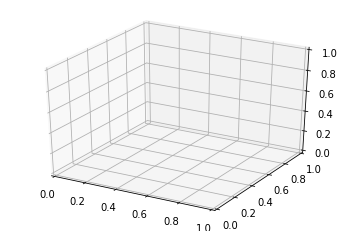

In [49]:
fig = plt.figure()
ax = plt.axes(projection='3d')

In [51]:
df.x1

0      0.010000
1      0.010000
2      0.010000
3      0.010000
4      0.010000
         ...   
120    0.000001
121    0.000001
122    0.000001
123    0.000001
124    0.000001
Name: x1, Length: 125, dtype: float64

Text(0.5, 0, 'x3')

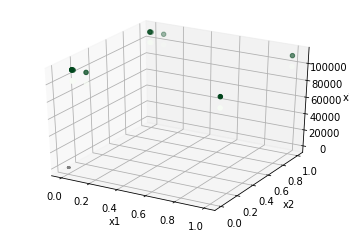

In [87]:

ax = plt.axes(projection='3d')

# Data for a three-dimensional line
x = df.x2
y = df.x3
z = df.npv
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
ax.scatter3D(x, y, z, c=z, cmap='Greens');


ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')